In [32]:
import pandas as pd

In [33]:
data = pd.read_csv('https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv')

### Exploración y limpieza de los datos

In [34]:
data

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


In [35]:
nan_dtypes = pd.DataFrame({
    'dtype': data.dtypes,
    'nan': data.isnull().sum(),
    "nunique": data.nunique()
})

nan_dtypes

,dtype,nan,nunique
Survived,int64,0,2
Pclass,int64,0,3
Name,object,0,887
Sex,object,0,2
Age,float64,0,89
Siblings/Spouses Aboard,int64,0,7
Parents/Children Aboard,int64,0,7
Fare,float64,0,248


Nuestro dataset parece estar completo y casi todas las variables tienen asignadas el dtype correcto.
1. Es necesario transformar el sex a una categórica.
¿Qué variables podemos descartar?

In [36]:
data = data.drop(columns=['Name'])

In [37]:
data["Pclass"] = data["Pclass"].astype('object')

In [38]:
data.dtypes

Survived                     int64
Pclass                      object
Sex                         object
Age                        float64
Siblings/Spouses Aboard      int64
Parents/Children Aboard      int64
Fare                       float64
dtype: object

In [39]:
encoded_df = pd.get_dummies(
    data,
    dtype=int
).drop(columns=['Sex_female'])

encoded_df.columns = ["survived", "age", "ss", "pc", "fare", "pclass_1", "pclass_2", "pclass_3", "sex"]
encoded_df

,survived,age,ss,pc,fare,pclass_1,pclass_2,pclass_3,sex
0,0,22.0,1,0,7.2500,0,0,1,1
1,1,38.0,1,0,71.2833,1,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,0
3,1,35.0,1,0,53.1000,1,0,0,0
4,0,35.0,0,0,8.0500,0,0,1,1
...,...,...,...,...,...,...,...,...,...
882,0,27.0,0,0,13.0000,0,1,0,1
883,1,19.0,0,0,30.0000,1,0,0,0
884,0,7.0,1,2,23.4500,0,0,1,0
885,1,26.0,0,0,30.0000,1,0,0,1


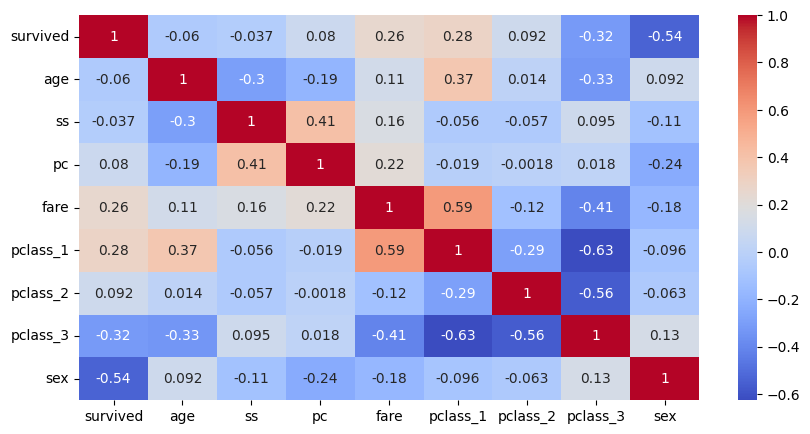

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(encoded_df.corr(), annot=True, cmap='coolwarm')
plt.show()

Vemos como las variables con una mayor correlación con survived es pclass_3, sex y fare. Se puede argumentar que hasta cierto punto hay una redundancia entre pclass_3 y pclass_1.

In [41]:
encoded_df = encoded_df.drop(columns=["pclass_2", "pclass_1", "pc", "ss", "age"])

In [42]:
encoded_df

,survived,fare,pclass_3,sex
0,0,7.2500,1,1
1,1,71.2833,0,0
2,1,7.9250,1,0
3,1,53.1000,0,0
4,0,8.0500,1,1
...,...,...,...,...
882,0,13.0000,0,1
883,1,30.0000,0,0
884,0,23.4500,1,0
885,1,30.0000,0,1


In [43]:
#El dataset está un poquito desbalanceado entonces el modelo aprenderá mejor cómo
#predecir quién no sobrevió que quién sobrevivió
#Si lo que buscamos es mejorar recall, entonces es necesario balancear el dataset.
encoded_df["survived"].value_counts()

survived
0    545
1    342
Name: count, dtype: int64

### Definición y entrenamiento de modelo

In [44]:
encoded_df

,survived,fare,pclass_3,sex
0,0,7.2500,1,1
1,1,71.2833,0,0
2,1,7.9250,1,0
3,1,53.1000,0,0
4,0,8.0500,1,1
...,...,...,...,...
882,0,13.0000,0,1
883,1,30.0000,0,0
884,0,23.4500,1,0
885,1,30.0000,0,1


In [45]:
from sklearn.model_selection import train_test_split

X, y = encoded_df.drop(columns=['survived']), encoded_df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
    max_depth=2,
    random_state=42
)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [47]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

y_pred = tree.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")


Accuracy: 0.7378277153558053
Recall: 0.3564356435643564
Precision: 0.8780487804878049
F1 Score: 0.5070422535211268


In [48]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': tree.feature_importances_
}).sort_values('importance', ascending=False)
importance_df

,feature,importance
2,sex,0.767490
1,pclass_3,0.207416
0,fare,0.025094
